In [1]:
import os
import time
import numpy as np
import h5py
import numpy.ma as ma
from jnormcorre.motion_correction import MotionCorrect
from ScanImageTiffReader import ScanImageTiffReader
from scipy.fft import fft2
import cv2
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
from scipy.ndimage import binary_dilation
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.cluster.hierarchy import fcluster
from scipy.ndimage import convolve, shift
from tifffile import tifffile
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from numba import jit, int64, float32, prange

In [2]:
from utils.xcorr2_nans import xcorr2_nans as cython_xcorr2_nans

def circshift(arr, shift, axes=None):
    """
    Circularly shift the elements of an array.

    Parameters:
    - arr (np.ndarray): Input array to be shifted.
    - shift (int, list, or np.ndarray): Number of places by which elements are shifted.
        - If an integer, the same shift is applied to all axes.
        - If a list or np.ndarray, each element specifies the shift for the corresponding axis.
    - axes (int, list of ints, or None, optional): Axis or axes along which to shift.
        - If None and shift is an integer, shift is applied to all axes.
        - If None and shift is a list/array, the length of shift must match the number of dimensions in arr.
        - Can be an integer or a list of integers corresponding to the axes.

    Returns:
    - np.ndarray: The shifted array.

    Raises:
    - ValueError: If the length of shift does not match the number of specified axes.
    """
    arr = np.asarray(arr)
    ndim = arr.ndim

    # Handle the axes parameter
    if axes is None:
        if isinstance(shift, (int, float)):
            axes = tuple(range(ndim))
            shift = (int(shift),) * ndim
        else:
            shift = tuple(int(s) for s in shift)
            if len(shift) != ndim:
                raise ValueError("Length of shift array must match number of dimensions of arr.")
            axes = tuple(range(ndim))
    else:
        if isinstance(axes, int):
            axes = (axes,)
        elif isinstance(axes, (list, tuple, np.ndarray)):
            axes = tuple(axes)
        else:
            raise ValueError("axes must be an int or a list/tuple of ints.")

        if isinstance(shift, (int, float)):
            shift = (int(shift),) * len(axes)
        else:
            shift = tuple(int(s) for s in shift)
            if len(shift) != len(axes):
                raise ValueError("Length of shift array must match number of specified axes.")

    # Apply the shifts
    for axis, s in zip(axes, shift):
        arr = np.roll(arr, shift=s, axis=axis)

    return arr
    
def dftups(inp, nor, noc, usfac, roff=0, coff=0):
    nr, nc = inp.shape
    # Compute kernels and obtain DFT by matrix products
    kernc = np.exp(
        (-1j * 2 * np.pi / (nc * usfac))
        * (np.fft.ifftshift(np.arange(nc)) - np.floor(nc/2)).reshape(-1, 1)
        @ (np.arange(noc) - coff).reshape(1, -1)
    )
    kernr = np.exp(
        (-1j * 2 * np.pi / (nr * usfac))
        * (np.arange(nor).reshape(-1, 1) - roff)
        @ (np.fft.ifftshift(np.arange(nr)) - np.floor(nr/2)).reshape(1, -1)
    )
    out = kernr @ inp @ kernc
    return out
    
def dftregistration_clipped(buf1ft, buf2ft, usfac=1, clip=None):
    if clip is None:
        clip = [0, 0]
    elif isinstance(clip, (int, float)):
        clip = [clip, clip]

    # Compute error for no pixel shift
    if usfac == 0:
        CCmax = np.sum(buf1ft * np.conj(buf2ft))
        rfzero = np.sum(np.abs(buf1ft.flatten()) ** 2)
        rgzero = np.sum(np.abs(buf2ft.flatten()) ** 2)
        error = 1.0 - CCmax * np.conj(CCmax) / (rgzero * rfzero)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
        output = [error, diffphase]
        return output, None

    # Whole-pixel shift - Compute crosscorrelation by an IFFT and locate the peak
    elif usfac == 1:
        m, n = buf1ft.shape
        md2 = m // 2
        nd2 = n // 2
        CC = np.fft.ifft2(buf1ft * np.conj(buf2ft))

        keep = np.ones(CC.shape, dtype=bool)
        keep[clip[0] // 2 + 1 : -clip[0] // 2, :] = False
        keep[:, clip[1] // 2 + 1 : -clip[1] // 2] = False
        CC[~keep] = 0

        max1 = np.max(np.real(CC), axis=0)
        loc1 = np.argmax(np.real(CC), axis=0)
        max2 = np.max(max1)
        loc2 = np.argmax(max1)
        rloc = loc1[loc2]
        cloc = loc2
        CCmax = CC[rloc, cloc]
        rfzero = np.sum(np.abs(buf1ft.flatten()) ** 2) / (m * n)
        rgzero = np.sum(np.abs(buf2ft.flatten()) ** 2) / (m * n)
        error = 1.0 - CCmax * np.conj(CCmax) / (rgzero * rfzero)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))

        md2 = m // 2
        nd2 = n // 2
        if rloc > md2:
            row_shift = rloc - m - 1  # Add the -1
        else:
            row_shift = rloc - 1      # Add the -1

        if cloc > nd2:
            col_shift = cloc - n - 1  # Add the -1
        else:
            col_shift = cloc - 1      # Add the -1

        output = [error, diffphase, row_shift, col_shift]
        return output, None

    # Partial-pixel shift
    else:
        m, n = buf1ft.shape
        mlarge = m * 2
        nlarge = n * 2
        CC = np.zeros((mlarge, nlarge), dtype=np.complex128)
        # CC[
        #     m - (m // 2) : m + (m // 2),
        #     n - (n // 2) : n + (n // 2),
        # ] = np.fft.fftshift(buf1ft) * np.conj(np.fft.fftshift(buf2ft))
        CC[m//2:m//2 + m, n//2:n//2 + n] = np.fft.fftshift(buf1ft) * np.conj(np.fft.fftshift(buf2ft))
        # Compute crosscorrelation and locate the peak
        CC = np.fft.ifft2(np.fft.ifftshift(CC))  # Calculate cross-correlation

        keep = np.ones(CC.shape, dtype=bool)
        keep[2 * clip[0] + 1 : -2 * clip[0], :] = False
        keep[:, 2 * clip[1] + 1 : -2 * clip[1]] = False
        CC[~keep] = 0

        max1 = np.max(np.real(CC), axis=1)
        loc1 = np.argmax(np.real(CC), axis=1)
        max2 = np.max(max1)
        loc2 = np.argmax(max1)
        max_val = np.max(np.real(CC))
        rloc, cloc = np.unravel_index(np.argmax(np.real(CC)), CC.shape)
        CCmax = CC[rloc, cloc]

        # Obtain shift in original pixel grid from the position of the
        # crosscorrelation peak
        m, n = CC.shape
        md2 = m // 2
        nd2 = n // 2
        if rloc > md2:
            row_shift = rloc - m
        else:
            row_shift = rloc
        if cloc > nd2:
            col_shift = cloc - n
        else:
            col_shift = cloc
        row_shift = row_shift / 2
        col_shift = col_shift / 2

        # If upsampling > 2, then refine estimate with matrix multiply DFT
        if usfac > 2:
            # Initial shift estimate in upsampled grid
            row_shift = round(row_shift * usfac) / usfac
            col_shift = round(col_shift * usfac) / usfac
            dftshift = np.fix(np.ceil(usfac * 1.5) / 2)  # Center of output array at dftshift+1
            # Matrix multiply DFT around the current shift estimate
            CC = np.conj(
                dftups(
                    buf2ft * np.conj(buf1ft),
                    np.ceil(usfac * 1.5),
                    np.ceil(usfac * 1.5),
                    usfac,
                    dftshift - row_shift * usfac,
                    dftshift - col_shift * usfac,
                )
            ) / (md2 * nd2 * usfac ** 2)
            # Locate maximum and map back to original pixel grid
            max1 = np.max(np.real(CC), axis=0) #<--------- was set to axis 0
            loc1 = np.argmax(np.real(CC), axis=0) #<--------- was set to axis 0
            max2 = np.max(max1)
            loc2 = np.argmax(max1)
            rloc = loc1[loc2]
            cloc = loc2
            CCmax = CC[rloc, cloc]
            rg00 = dftups(buf1ft * np.conj(buf1ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
            rf00 = dftups(buf2ft * np.conj(buf2ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
            rloc = rloc - dftshift
            cloc = cloc - dftshift
            row_shift = row_shift + rloc / usfac
            col_shift = col_shift + cloc / usfac

            # If upsampling = 2, no additional pixel shift refinement
        else:
            rg00 = np.sum(buf1ft * np.conj(buf1ft)) / m / n
            rf00 = np.sum(buf2ft * np.conj(buf2ft)) / m / n
        error = 1.0 - CCmax * np.conj(CCmax) / (rg00 * rf00)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
        # If its only one row or column the shift along that dimension has no
        # effect. We set to zero.
        if md2 == 1:
            row_shift = 0
        if nd2 == 1:
            col_shift = 0
        output = [error, diffphase, row_shift, col_shift]

        # Compute registered version of buf2ft
        if usfac > 0:
            nr, nc = buf2ft.shape
            Nr = np.fft.ifftshift(np.arange(-np.fix(nr / 2), np.ceil(nr / 2)))
            Nc = np.fft.ifftshift(np.arange(-np.fix(nc / 2), np.ceil(nc / 2)))
            Nc, Nr = np.meshgrid(Nc, Nr)
            Greg = buf2ft * np.exp(
                1j * 2 * np.pi * (-row_shift * Nr / nr - col_shift * Nc / nc)
            )
            Greg = Greg * np.exp(1j * diffphase)
        elif usfac == 0:
            Greg = buf2ft * np.exp(1j * diffphase)
        else:
            Greg = None
    return output, Greg
    
def fast_xcorr2_nans(frame, template, shiftsCenter, dShift):
    dShift = round(dShift)  # Sanity check

    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.uint8)

    # Valid pixels of the new frame
    rows, cols = template.shape
    M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])
    tmp = cv2.warpAffine(1-cv2.dilate(np.isnan(template).astype(np.uint8), SE, iterations=1), M, (cols, rows),
                            borderMode=cv2.BORDER_CONSTANT, flags=cv2.INTER_NEAREST).astype(bool)
    fValid = np.zeros(frame.shape, dtype=bool)
    fValid[dShift:-dShift, dShift:-dShift] = ~np.isnan(frame[dShift:-dShift, dShift:-dShift]) & tmp[dShift:-dShift, dShift:-dShift]

    tValid = np.roll(fValid, -shiftsCenter, axis=(0, 1)).astype(bool)

    F = frame[fValid]
    ssF = np.sqrt(F.dot(F))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    tV0, tV1 = np.where(tValid)
    tValidInd = tV0 * cols + tV1

    shifts = np.arange(-dShift, dShift + 1)
    C = np.full((len(shifts), len(shifts)), np.nan)
    # Print datatypes before the loop
    for drix, shift_x in enumerate(shifts):
        for dcix, shift_y in enumerate(shifts):
            shifted_tValid = np.roll(tValid, (-shift_x, -shift_y), axis=(0, 1))
            T = template[shifted_tValid]
            ssT = np.sum(T ** 2)
            
            if ssT > 0:  # Only calculate if ssT is greater than zero
                C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)
            else:
                C[drix, dcix] = np.nan  # Handle cases where ssT is zero
            
    # plt.imshow(C)
    # Find maximum of correlation map
    maxval = np.nanmax(C)
    I = np.unravel_index(np.nanargmax(C), C.shape)
    rr, cc = I
    R = maxval / ssF  # Correlation coefficient

    if 0 < rr < len(shifts) - 1 and 0 < cc < len(shifts) - 1:
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        motion = shiftsCenter + [shifts[rr] - dR, shifts[cc] - dC]
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + [shifts[rr], shifts[cc]]

    if np.any(np.isnan(motion)):
        raise ValueError('Motion result contains NaN values')

    return motion, R

def matlab_round(x):
    """
    Replicates MATLAB's round function behavior
    
    In MATLAB:
    - round(4.5) = 5
    - round(-4.5) = -5
    """
    if x >= 0:
        return int(np.floor(x + 0.5))
    else:
        return int(np.ceil(x - 0.5))
        
def downsampleTime(Y, ds_time):
    for _ in range(ds_time):
        Y = Y[:, :, :, :2*(Y.shape[3]//2):2] + Y[:, :, :, 1:2*(Y.shape[3]//2):2]
    return Y

In [3]:
# ---------------Adrian:

import h5py
import numpy as np
from scipy.io import loadmat

# Load the MATLAB v7.3 file
file_path = '/root/capsule/scratch/Matlab-variables/adrian_motion_bug.mat'
mat = loadmat(file_path)

# List all variables in the file
Ad = mat['Ad'][:]
# Ad = np.transpose(Ad, (3, 2, 1, 0))
T0 = mat['T0'][:]
T00 = mat['T00'][:]
template = mat['template'][:]
templateFull = template
nDSframes = 6449
numChannels = 1
selCh = list(range(numChannels))
clipShift = 10
initR = 0 
initC = 0
sz = [46, 128, 1, 51597]
templateCt = np.zeros_like(template)
selCh = list(range(numChannels))

# Initialize arrays to store the inferred motion and errors
motionDSr = np.nan * np.ones(nDSframes)
motionDSc = np.nan * np.ones(nDSframes)
aErrorDS = np.nan * np.ones(nDSframes)
aRankCorr = np.nan * np.ones(nDSframes)
recNegErr = np.nan * np.ones(nDSframes)

dsFac = 8
ds_time = 3

# Create view matrices for interpolation
maxshift = 50  # Define maxshift if not already defined
viewR, viewC = np.meshgrid(
    np.arange(0, sz[0] + 2 * maxshift) - maxshift,
    np.arange(0, sz[1] + 2 * maxshift) - maxshift,
    indexing='ij'
)
output = 0
# Remember to close the file when done|
# mat.close()

In [3]:
# Michael ------------------->

file_path = '/root/capsule/scratch/Michael_data.mat'
mat = h5py.File(file_path, 'r')

# List all variables in the file
Ad = mat['Ad'][:]
Ad = np.transpose(Ad, (3, 2, 1, 0))
T0 = mat['T0'][:].T
T00 = mat['T00'][:].T
template = mat['template'][:].T
templateFull = template

nDSframes = 21068
numChannels = 2
selCh = list(range(numChannels))
clipShift = 10
initR = 0 
initC = 0
sz = [46, 128, 2, 168551]
templateCt = np.zeros_like(template)

# Initialize arrays to store the inferred motion and errors
motionDSr = np.nan * np.ones(nDSframes)
motionDSc = np.nan * np.ones(nDSframes)
aErrorDS = np.nan * np.ones(nDSframes)
aRankCorr = np.nan * np.ones(nDSframes)
recNegErr = np.nan * np.ones(nDSframes)

dsFac = 8
ds_time = 3

# Create view matrices for interpolation
maxshift = 50  # Define maxshift if not already defined
viewR, viewC = np.meshgrid(
    np.arange(0, sz[0] + 2 * maxshift) - maxshift,
    np.arange(0, sz[1] + 2 * maxshift) - maxshift,
    indexing='ij'
)

In [4]:
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
from scipy.fftpack import fft2
# Assume downsampleTime, dftregistration_clipped, and xcorr2_nans are defined elsewhere

initR = 0 
initC = 0
output = 0

# Initialize arrays to store the inferred motion and errors
motionDSr = np.nan * np.ones(nDSframes)
motionDSc = np.nan * np.ones(nDSframes)
aErrorDS = np.nan * np.ones(nDSframes)
aRankCorr = np.nan * np.ones(nDSframes)
recNegErr = np.nan * np.ones(nDSframes)

# Define the grid for interpolation
y = np.arange(sz[0])
x = np.arange(sz[1])

for DSframe in range(nDSframes):
    if DSframe == 410:
        break
    
    read_start = DSframe * dsFac
    read_end = read_start + dsFac
    readFrames = np.arange(read_start, read_end)
    
    M = downsampleTime(Ad[:, :, :, readFrames], ds_time)
    M = np.sum(M[:,:,selCh,:].reshape(M.shape[0], M.shape[1], -1, M.shape[3]), axis=2).squeeze()
    
    if DSframe % 1000 == 0:
        print(f'{DSframe} of {nDSframes}')

    # print('DFT RegisL:', output)

    Ttmp = np.nanmean(np.stack((T0, T00, template), axis=2), axis=2)
    T = Ttmp[
    maxshift - initR : maxshift - initR + sz[0],
    maxshift - initC : maxshift - initC + sz[1]
    ]
    
    output,_ = dftregistration_clipped(fft2(M.astype(np.float32)), fft2(T.astype(np.float32)), 4, clipShift)
    
    motionDSr[DSframe] = initR + output[2]
    motionDSc[DSframe] = initC + output[3]
    aErrorDS[DSframe] = output[0].item()  
    
    if np.sqrt((motionDSr[DSframe]/sz[0])**2 + (motionDSc[DSframe]/sz[1])**2) > 0.75**2:
        x = np.arange(sz[1])
        y = np.arange(sz[0])
        mesh_x, mesh_y = np.meshgrid(x, y)
        
        start_cv2_remap = time.time()
        map_x = np.float32(viewC)
        map_y = np.float32(viewR)
        Mfull = cv2.remap(M.astype(np.float32), map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)
        
        motion, R = fast_xcorr2_nans(Mfull.astype(np.float32), Ttmp.astype(np.float32), np.array([initR, initC]), 50)
        print(f'{DSframe}', 'Xcorre:', motion, R)
        motionDSr[DSframe] = motion[0]
        motionDSc[DSframe] = motion[1]
        aErrorDS[DSframe] = R
    
    if abs(motionDSr[DSframe]) < maxshift and abs(motionDSc[DSframe]) < maxshift:
        X, Y = np.meshgrid(np.arange(0, sz[1]), np.arange(0, sz[0]))
        
        Xq = viewC + motionDSc[DSframe]
        Yq = viewR + motionDSr[DSframe]
        
        A = cv2.remap(M, Xq.astype(np.float32), Yq.astype(np.float32), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)
        
        Asmooth = cv2.GaussianBlur(A, (0, 0), sigmaX=1)
        
        selCorr = ~np.isnan(Asmooth) & ~np.isnan(Ttmp)
        if np.sum(selCorr) > 0:
            aRankCorr[DSframe] = np.corrcoef(Asmooth[selCorr].flatten(), Ttmp[selCorr].flatten())[0, 1]
            recNegErr[DSframe] = np.mean(
                np.minimum(0, Asmooth[selCorr] * np.mean(Ttmp[selCorr]) / np.mean(Asmooth[selCorr]) - Ttmp[selCorr]
            )**2)
        
        # Sum along the third dimension, ignoring NaNs
        templateFull = np.nansum(np.stack((templateFull * templateCt, A), axis=2), axis=2)

        # Update the count where A is not NaN
        templateCt = templateCt + ~np.isnan(A)

        # Compute the average
        # Safely divide, avoiding division by zero
        templateFull = np.divide(templateFull, templateCt, where=templateCt != 0)

        # Alternatively, you can fill in NaNs for places where templateCt is zero
        templateFull[templateCt == 0] = np.nan

        # Assign to template
        template = templateFull.copy()

        # Set values to NaN where the count is less than 100
        template[templateCt < 100] = np.nan
        
        initR = matlab_round(motionDSr[DSframe]) 
        initC = matlab_round(motionDSc[DSframe])
    else:
        motionDSr[DSframe] = initR
        motionDSc[DSframe] = initC

0 of 21068
338 Xcorre: [-6.84950811 -9.88421055] 0.3035741829370545
367 Xcorre: [ 4.13558276 -2.21690486] 0.3469598872375804


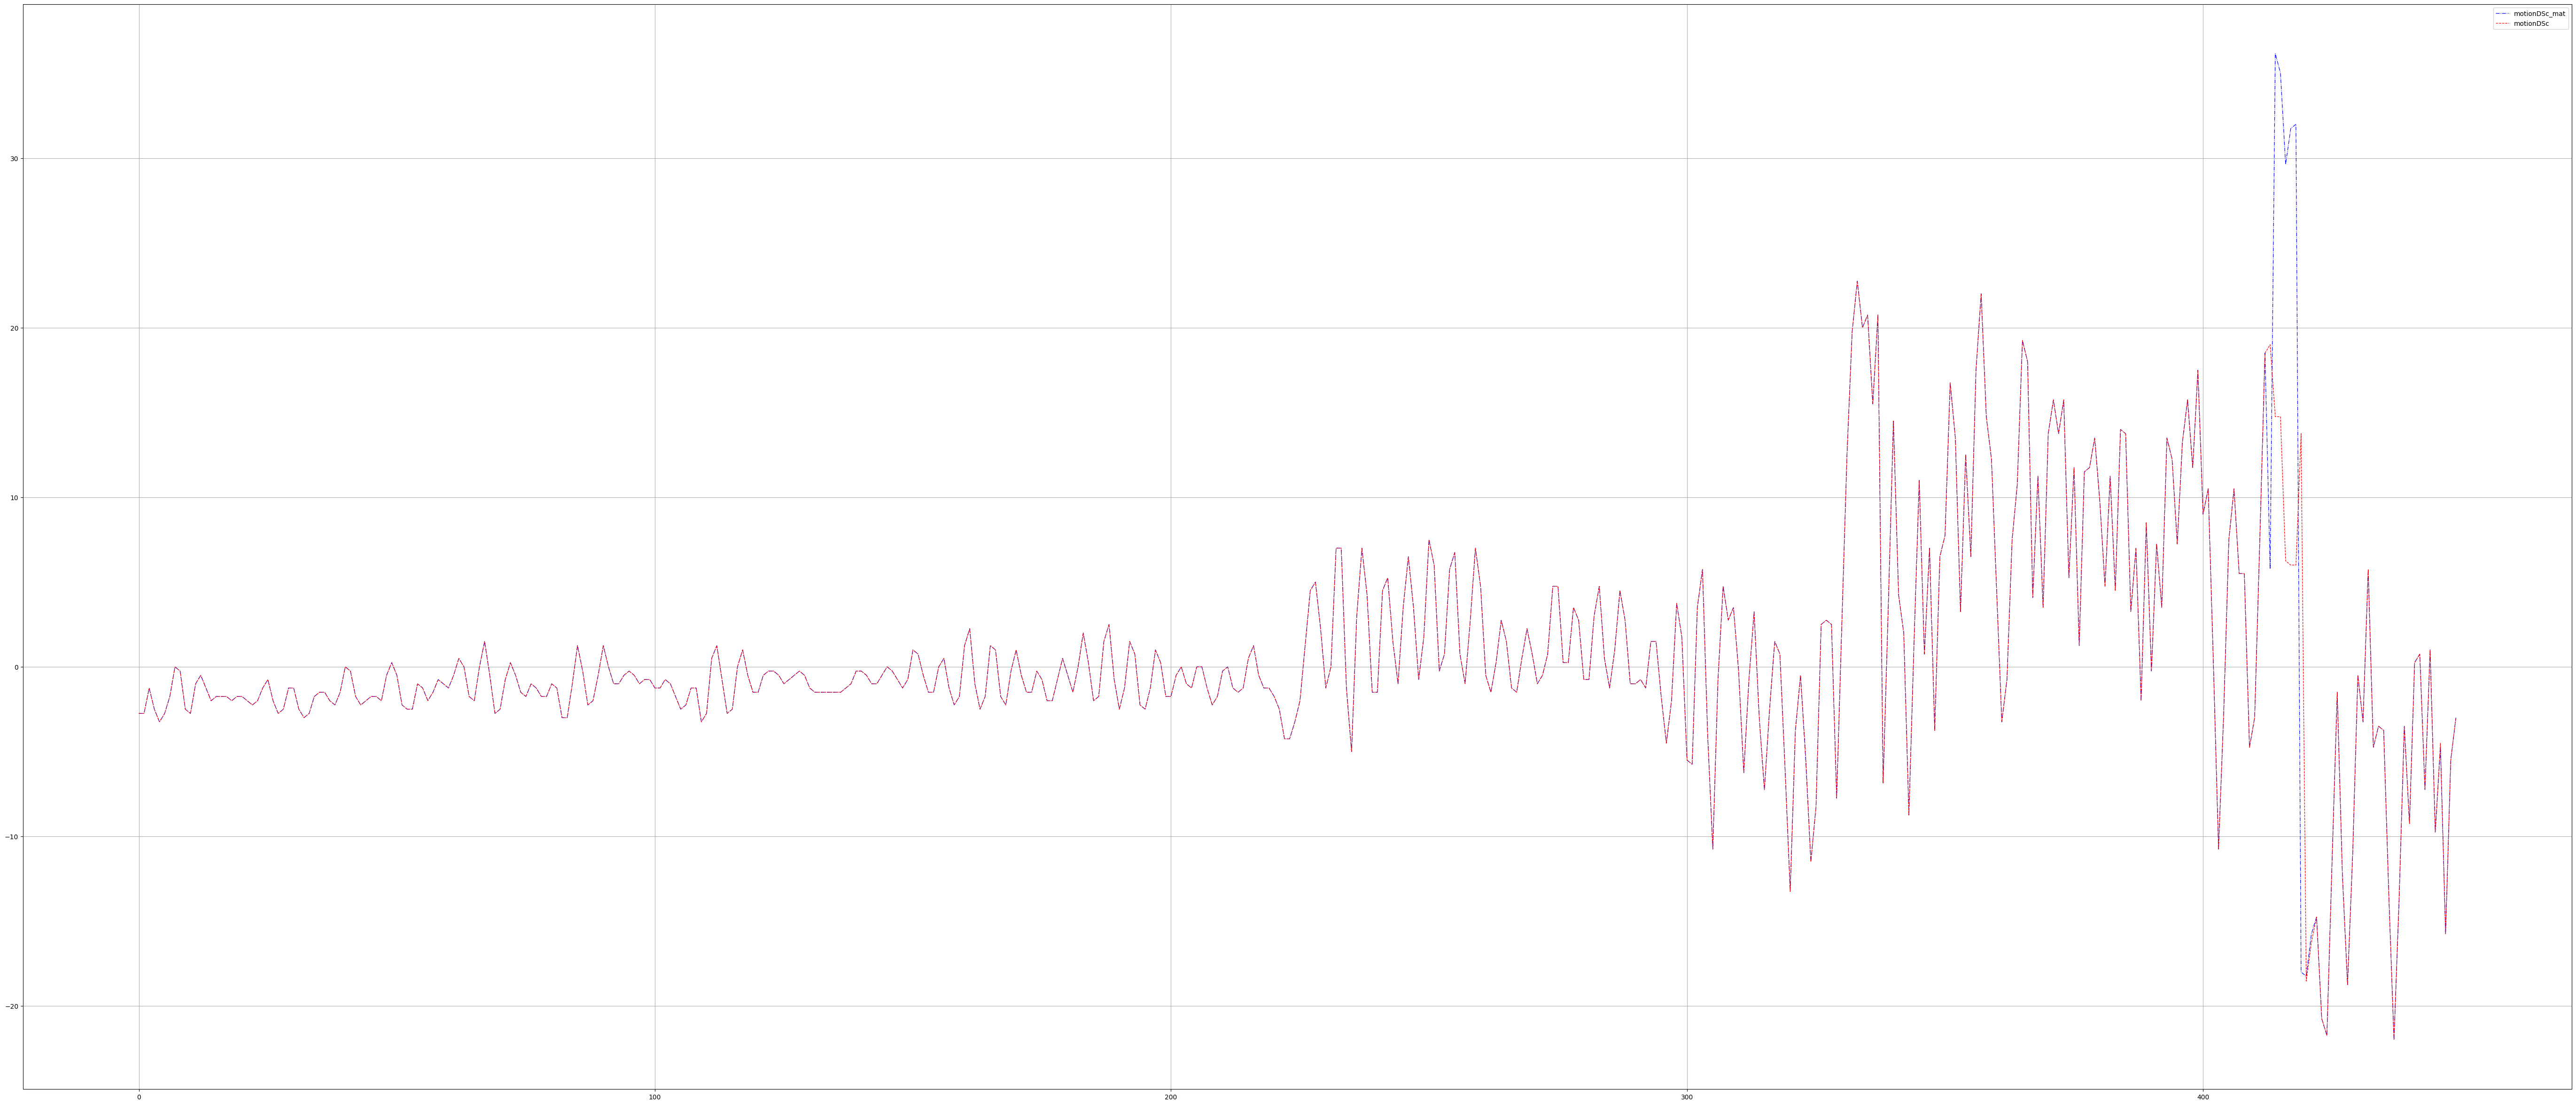

In [5]:
# Extract the motionDSc data
motionDSc_mat = loadmat('/root/capsule/scratch/Motion-michael.mat')['motionDSc'].squeeze()

# Extract the motionDSc data
motionDSr_mat = loadmat('/root/capsule/scratch/Motion-michael.mat')['motionDSr'].squeeze()

plt.figure(figsize=(70, 30))  # Set the figure size

# Plot the data with specified colors and line styles
plt.plot(motionDSr_mat[0:450], color='blue', label='motionDSc_mat', linestyle='dashdot', linewidth=0.9)
plt.plot(motionDSr[0:450], color='red', linestyle='--', label='motionDSc', linewidth=0.9)

# Add gridlines
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot

plt.show()

In [6]:
print('RMSE motionDSc--->', np.sqrt(np.mean((motionDSc - motionDSc_mat) ** 2)))
print('RMSE motionDSr--->', np.sqrt(np.mean((motionDSr - motionDSr_mat) ** 2)))

RMSE motionDSc---> 1.4474326340565231
RMSE motionDSr---> 1.2619348035527325


In [8]:
np.nanmax(np.abs(motionDSc - motionDSc_mat)), np.nanmax(np.abs(motionDSr - motionDSr_mat))

(69.45156436660604, 60.70668039303386)

In [36]:
# Interpolating motion DS to Motion C and R:


# **1. Time Vector Calculation (tDS)**
tDS = (np.arange(1, nDSframes + 1) * dsFac) - (2**(ds_time - 1)) + 0.5

# **2. Upsampling Points**
upsample_factor = 2 ** ds_time
desired_length = upsample_factor * nDSframes

# Use linspace to include the endpoint
upsample_points = np.linspace(1, desired_length, num=desired_length)

# **3. Interpolation for motionC**
motionC_interp = PchipInterpolator(tDS, motionDSc, extrapolate=True)
motionC = motionC_interp(upsample_points)

# **4. Interpolation for motionR**
motionR_interp = PchipInterpolator(tDS, motionDSr, extrapolate=True)
motionR = motionR_interp(upsample_points)

RMSE motionC---> 0.06155002916155491
RMSE motionR---> 0.036554513045468556


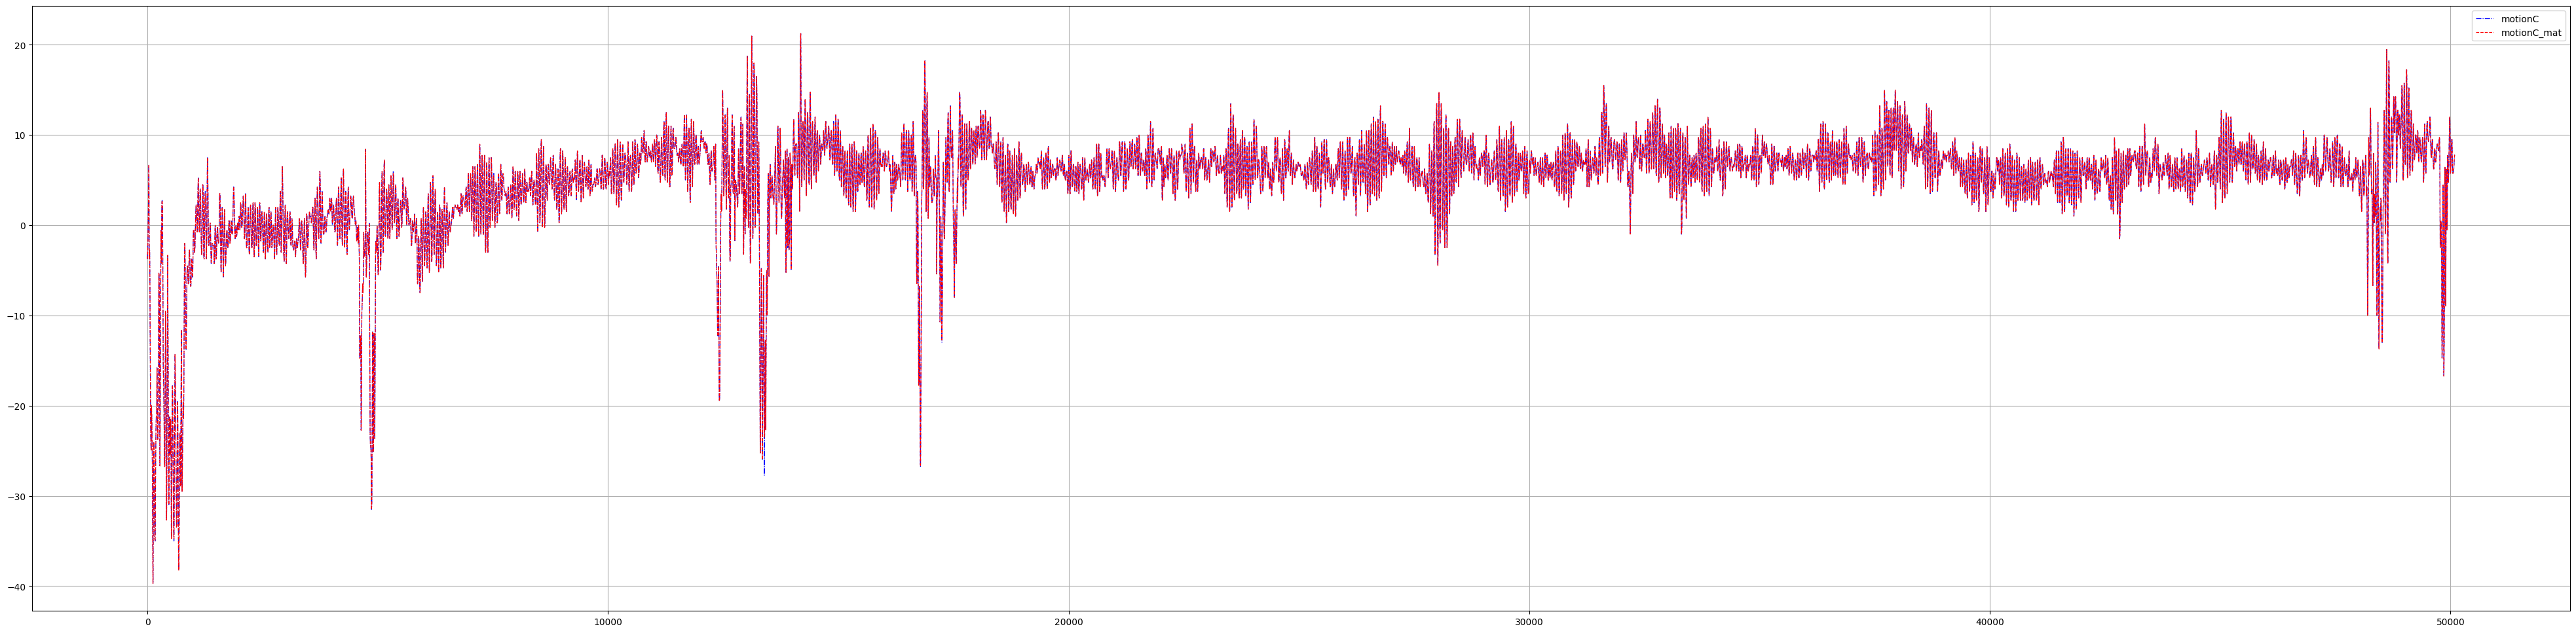

In [37]:
mat = loadmat('/root/capsule/scratch/Matlab-variables/MotionCR-adrian.mat')
motionC_mat = mat['motionC'].squeeze()
motionR_mat = mat['motionR'].squeeze()

print('RMSE motionC--->', np.sqrt(np.mean((motionC - motionC_mat) ** 2)))
print('RMSE motionR--->', np.sqrt(np.mean((motionR - motionR_mat) ** 2)))

# Set the figure size (width, height) in inches
plt.figure(figsize=(50, 12))

# Plot the data with specified colors and line styles
plt.plot(motionC_mat[1500:], color='blue', label='motionC', linestyle='dashdot', linewidth=0.9)
plt.plot(motionC[1500:], color='red', linestyle='--', label='motionC_mat', linewidth=0.9)

# Add gridlines
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot

plt.show()

# Test Dft registeration:

In [35]:
def dftups(inp, nor, noc, usfac, roff=0, coff=0):
    nr, nc = inp.shape
    # Compute kernels and obtain DFT by matrix products
    kernc = np.exp(
        (-1j * 2 * np.pi / (nc * usfac))
        * (np.fft.ifftshift(np.arange(nc)) - np.floor(nc/2)).reshape(-1, 1)
        @ (np.arange(noc) - coff).reshape(1, -1)
    )
    kernr = np.exp(
        (-1j * 2 * np.pi / (nr * usfac))
        * (np.arange(nor).reshape(-1, 1) - roff)
        @ (np.fft.ifftshift(np.arange(nr)) - np.floor(nr/2)).reshape(1, -1)
    )
    out = kernr @ inp @ kernc
    return out
    
def dftregistration_clipped(buf1ft, buf2ft, usfac=1, clip=None):
    if clip is None:
        clip = [0, 0]
    elif isinstance(clip, (int, float)):
        clip = [clip, clip]

    # Compute error for no pixel shift
    if usfac == 0:
        CCmax = np.sum(buf1ft * np.conj(buf2ft))
        rfzero = np.sum(np.abs(buf1ft.flatten()) ** 2)
        rgzero = np.sum(np.abs(buf2ft.flatten()) ** 2)
        error = 1.0 - CCmax * np.conj(CCmax) / (rgzero * rfzero)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
        output = [error, diffphase]
        return output, None

    # Whole-pixel shift - Compute crosscorrelation by an IFFT and locate the peak
    elif usfac == 1:
        m, n = buf1ft.shape
        md2 = m // 2
        nd2 = n // 2
        CC = np.fft.ifft2(buf1ft * np.conj(buf2ft))

        keep = np.ones(CC.shape, dtype=bool)
        keep[clip[0] // 2 + 1 : -clip[0] // 2, :] = False
        keep[:, clip[1] // 2 + 1 : -clip[1] // 2] = False
        CC[~keep] = 0

        max1 = np.max(np.real(CC), axis=1)
        loc1 = np.argmax(np.real(CC), axis=1)
        max2 = np.max(max1)
        loc2 = np.argmax(max1)
        rloc = loc1[loc2]
        cloc = loc2
        CCmax = CC[rloc, cloc]
        rfzero = np.sum(np.abs(buf1ft.flatten()) ** 2) / (m * n)
        rgzero = np.sum(np.abs(buf2ft.flatten()) ** 2) / (m * n)
        error = 1.0 - CCmax * np.conj(CCmax) / (rgzero * rfzero)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))

        md2 = m // 2
        nd2 = n // 2
        if rloc > md2:
            row_shift = rloc - m - 1  # Add the -1
        else:
            row_shift = rloc - 1      # Add the -1

        if cloc > nd2:
            col_shift = cloc - n - 1  # Add the -1
        else:
            col_shift = cloc - 1      # Add the -1

        output = [error, diffphase, row_shift, col_shift]
        return output, None

    # Partial-pixel shift
    else:
        # First upsample by a factor of 2 to obtain initial estimate
        # Embed Fourier data in a 2x larger array
        m, n = buf1ft.shape
        mlarge = m * 2
        nlarge = n * 2
        CC = np.zeros((mlarge, nlarge), dtype=np.complex128)
        CC[
            m - (m // 2) : m + (m // 2),
            n - (n // 2) : n + (n // 2),
        ] = np.fft.fftshift(buf1ft) * np.conj(np.fft.fftshift(buf2ft))

        # Compute crosscorrelation and locate the peak
        CC = np.fft.ifft2(np.fft.ifftshift(CC))  # Calculate cross-correlation

        keep = np.ones(CC.shape, dtype=bool)
        keep[2 * clip[0] + 1 : -2 * clip[0], :] = False
        keep[:, 2 * clip[1] + 1 : -2 * clip[1]] = False
        CC[~keep] = 0

        max1 = np.max(np.real(CC), axis=1)
        loc1 = np.argmax(np.real(CC), axis=1)
        max2 = np.max(max1)
        loc2 = np.argmax(max1)
        max_val = np.max(np.real(CC))
        rloc, cloc = np.unravel_index(np.argmax(np.real(CC)), CC.shape)
        CCmax = CC[rloc, cloc]

        # Obtain shift in original pixel grid from the position of the
        # crosscorrelation peak
        m, n = CC.shape
        md2 = m // 2
        nd2 = n // 2
        if rloc > md2:
            row_shift = rloc - m
        else:
            row_shift = rloc
        if cloc > nd2:
            col_shift = cloc - n
        else:
            col_shift = cloc
        row_shift = row_shift / 2
        col_shift = col_shift / 2

        # If upsampling > 2, then refine estimate with matrix multiply DFT
        if usfac > 2:
            # Initial shift estimate in upsampled grid
            row_shift = round(row_shift * usfac) / usfac
            col_shift = round(col_shift * usfac) / usfac
            dftshift = np.fix(np.ceil(usfac * 1.5) / 2)  # Center of output array at dftshift+1
            # Matrix multiply DFT around the current shift estimate
            CC = np.conj(
                dftups(
                    buf2ft * np.conj(buf1ft),
                    np.ceil(usfac * 1.5),
                    np.ceil(usfac * 1.5),
                    usfac,
                    dftshift - row_shift * usfac,
                    dftshift - col_shift * usfac,
                )
            ) / (md2 * nd2 * usfac ** 2)
            # Locate maximum and map back to original pixel grid
            max1 = np.max(np.real(CC), axis=0)
            loc1 = np.argmax(np.real(CC), axis=0)
            max2 = np.max(max1)
            loc2 = np.argmax(max1)
            rloc = loc1[loc2]
            cloc = loc2
            CCmax = CC[rloc, cloc]
            rg00 = dftups(buf1ft * np.conj(buf1ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
            rf00 = dftups(buf2ft * np.conj(buf2ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
            rloc = rloc - dftshift
            cloc = cloc - dftshift
            row_shift = row_shift + rloc / usfac
            col_shift = col_shift + cloc / usfac

        # If upsampling = 2, no additional pixel shift refinement
        else:
            rg00 = np.sum(buf1ft * np.conj(buf1ft)) / m / n
            rf00 = np.sum(buf2ft * np.conj(buf2ft)) / m / n
        error = 1.0 - CCmax * np.conj(CCmax) / (rg00 * rf00)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
        # If its only one row or column the shift along that dimension has no
        # effect. We set to zero.
        if md2 == 1:
            row_shift = 0
        if nd2 == 1:
            col_shift = 0
        output = [error, diffphase, row_shift, col_shift]

    # Compute registered version of buf2ft
    if usfac > 0:
        nr, nc = buf2ft.shape
        Nr = np.fft.ifftshift(np.arange(-np.fix(nr / 2), np.ceil(nr / 2)))
        Nc = np.fft.ifftshift(np.arange(-np.fix(nc / 2), np.ceil(nc / 2)))
        Nc, Nr = np.meshgrid(Nc, Nr)
        Greg = buf2ft * np.exp(
            1j * 2 * np.pi * (-row_shift * Nr / nr - col_shift * Nc / nc)
        )
        Greg = Greg * np.exp(1j * diffphase)
    elif usfac == 0:
        Greg = buf2ft * np.exp(1j * diffphase)
    else:
        Greg = None

    return output, Greg

In [36]:
from scipy.io import loadmat

buf1ft = loadmat('/root/capsule/scratch/DFT_2.mat')['buf1ft']
buf2ft = loadmat('/root/capsule/scratch/DFT_2.mat')['buf2ft']
clip = [10, 10]
usfac = 4



In [37]:
output,_ = dftregistration_clipped(buf1ft, buf2ft, 4, [10, 10])

In [39]:
output

[array([[0.77149156]]), 0.000287513568986088, -6.5, -4.0]

In [87]:
m, n = buf1ft.shape
mlarge = m * 2
nlarge = n * 2
CC = np.zeros((mlarge, nlarge), dtype=np.complex128)
CC[
    m - (m // 2) : m + (m // 2),
    n - (n // 2) : n + (n // 2),
] = np.fft.fftshift(buf1ft) * np.conj(np.fft.fftshift(buf2ft))

# Compute crosscorrelation and locate the peak
CC = np.fft.ifft2(np.fft.ifftshift(CC))  # Calculate cross-correlation

keep = np.ones(CC.shape, dtype=bool)
keep[2 * clip[0] + 1 : -2 * clip[0], :] = False
keep[:, 2 * clip[1] + 1 : -2 * clip[1]] = False
CC[~keep] = 0

max1 = np.max(np.real(CC), axis=1)
loc1 = np.argmax(np.real(CC), axis=1)
max2 = np.max(max1)
loc2 = np.argmax(max1)
max_val = np.max(np.real(CC))
rloc, cloc = np.unravel_index(np.argmax(np.real(CC)), CC.shape)
CCmax = CC[rloc, cloc]

# Obtain shift in original pixel grid from the position of the
# crosscorrelation peak
m, n = CC.shape
md2 = m // 2
nd2 = n // 2
if rloc > md2:
    row_shift = rloc - m
else:
    row_shift = rloc
if cloc > nd2:
    col_shift = cloc - n
else:
    col_shift = cloc
row_shift = row_shift / 2
col_shift = col_shift / 2

# If upsampling > 2, then refine estimate with matrix multiply DFT
if usfac > 2:
    # Initial shift estimate in upsampled grid
    row_shift = round(row_shift * usfac) / usfac
    col_shift = round(col_shift * usfac) / usfac
    dftshift = np.fix(np.ceil(usfac * 1.5) / 2)  # Center of output array at dftshift+1
    # Matrix multiply DFT around the current shift estimate
    CC = np.conj(
        dftups(
            buf2ft * np.conj(buf1ft),
            np.ceil(usfac * 1.5),
            np.ceil(usfac * 1.5),
            usfac,
            dftshift - row_shift * usfac,
            dftshift - col_shift * usfac,
        )
    ) / (md2 * nd2 * usfac ** 2)
    # Locate maximum and map back to original pixel grid
    max1 = np.max(np.real(CC), axis=0) #<--------- was set to axis 0
    loc1 = np.argmax(np.real(CC), axis=0) #<--------- was set to axis 0
    max2 = np.max(max1)
    loc2 = np.argmax(max1)
    rloc = loc1[loc2]
    cloc = loc2
    CCmax = CC[rloc, cloc]
    rg00 = dftups(buf1ft * np.conj(buf1ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
    rf00 = dftups(buf2ft * np.conj(buf2ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
    rloc = rloc - dftshift
    cloc = cloc - dftshift
    row_shift = row_shift + rloc / usfac
    col_shift = col_shift + cloc / usfac

    # If upsampling = 2, no additional pixel shift refinement
else:
    rg00 = np.sum(buf1ft * np.conj(buf1ft)) / m / n
    rf00 = np.sum(buf2ft * np.conj(buf2ft)) / m / n
error = 1.0 - CCmax * np.conj(CCmax) / (rg00 * rf00)
error = np.sqrt(np.abs(error))
diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
# If its only one row or column the shift along that dimension has no
# effect. We set to zero.
if md2 == 1:
    row_shift = 0
if nd2 == 1:
    col_shift = 0
output = [error, diffphase, row_shift, col_shift]

# Compute registered version of buf2ft
if usfac > 0:
    nr, nc = buf2ft.shape
    Nr = np.fft.ifftshift(np.arange(-np.fix(nr / 2), np.ceil(nr / 2)))
    Nc = np.fft.ifftshift(np.arange(-np.fix(nc / 2), np.ceil(nc / 2)))
    Nc, Nr = np.meshgrid(Nc, Nr)
    Greg = buf2ft * np.exp(
        1j * 2 * np.pi * (-row_shift * Nr / nr - col_shift * Nc / nc)
    )
    Greg = Greg * np.exp(1j * diffphase)
elif usfac == 0:
    Greg = buf2ft * np.exp(1j * diffphase)
else:
    Greg = None

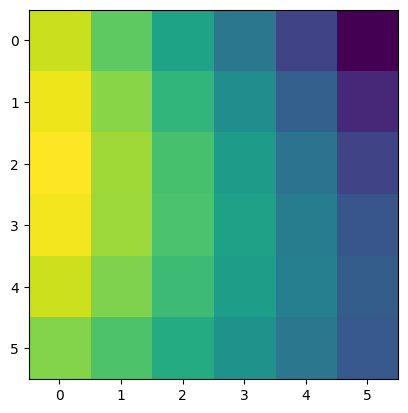

In [66]:
plt.imshow(np.abs(CC), cmap='viridis')

In [88]:
output

[array([[0.78033779]]), 0.00014707142210911177, 3.25, -10.75]

In [84]:
error

array([[0.78033779]])

# Test xcore

In [2]:
def circshift(arr, shift, axes=None):
    """
    Circularly shift the elements of an array.

    Parameters:
    - arr (np.ndarray): Input array to be shifted.
    - shift (int, list, or np.ndarray): Number of places by which elements are shifted.
        - If an integer, the same shift is applied to all axes.
        - If a list or np.ndarray, each element specifies the shift for the corresponding axis.
    - axes (int, list of ints, or None, optional): Axis or axes along which to shift.
        - If None and shift is an integer, shift is applied to all axes.
        - If None and shift is a list/array, the length of shift must match the number of dimensions in arr.
        - Can be an integer or a list of integers corresponding to the axes.

    Returns:
    - np.ndarray: The shifted array.

    Raises:
    - ValueError: If the length of shift does not match the number of specified axes.
    """
    arr = np.asarray(arr)
    ndim = arr.ndim

    # Handle the axes parameter
    if axes is None:
        if isinstance(shift, (int, float)):
            axes = tuple(range(ndim))
            shift = (int(shift),) * ndim
        else:
            shift = tuple(int(s) for s in shift)
            if len(shift) != ndim:
                raise ValueError("Length of shift array must match number of dimensions of arr.")
            axes = tuple(range(ndim))
    else:
        if isinstance(axes, int):
            axes = (axes,)
        elif isinstance(axes, (list, tuple, np.ndarray)):
            axes = tuple(axes)
        else:
            raise ValueError("axes must be an int or a list/tuple of ints.")

        if isinstance(shift, (int, float)):
            shift = (int(shift),) * len(axes)
        else:
            shift = tuple(int(s) for s in shift)
            if len(shift) != len(axes):
                raise ValueError("Length of shift array must match number of specified axes.")

    # Apply the shifts
    for axis, s in zip(axes, shift):
        arr = np.roll(arr, shift=s, axis=axis)

    return arr

In [3]:
from utils.xcorr2_nans import xcorr2_nans as cython_xcorr2_nans

def fast_xcorr2_nans(frame, template, shiftsCenter, dShift):
    """
    Perform a somewhat-efficient local normalized cross-correlation for images with NaNs.
    
    Parameters:
    - frame: the frame to be aligned; this has more NaNs
    - template: the template
    - shiftsCenter: the center offset around which to perform a local search
    - dShift: the maximum shift (scalar, in pixels) to consider on each axis around shiftsCenter
    
    Returns:
    - motion: the calculated motion vector
    - R: the correlation coefficient
    """
    # Create structuring element for dilation
    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.uint8)

    # Valid pixels of the new frame
    rows, cols = template.shape
    M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])
    tmp = cv2.warpAffine(1-cv2.dilate(np.isnan(template).astype(np.uint8), SE, iterations=1), M, (cols, rows),
                            borderMode=cv2.BORDER_CONSTANT, flags=cv2.INTER_NEAREST).astype(bool)
    fValid = np.zeros(frame.shape, dtype=bool)
    fValid[dShift:-dShift, dShift:-dShift] = ~np.isnan(frame[dShift:-dShift, dShift:-dShift]) & tmp[dShift:-dShift, dShift:-dShift]

    tValid = circshift(fValid, -shiftsCenter, axes=(0, 1)).astype(bool)

    F = frame[fValid]  # fixed data
    ssF = np.sqrt(F.dot(F))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    tV0, tV1 = np.where(tValid)
    tValidInd = tV0 * cols + tV1
    shifts = np.arange(-dShift, dShift + 1)
    C = np.full((len(shifts), len(shifts)), np.nan, dtype="f4")
    cython_xcorr2_nans(F.ravel(), template.ravel(), tValidInd.astype("i4"), shifts.astype("i4"), cols, C)
               
    # Find maximum of correlation map
    maxval = np.nanmax(C)
    if np.isnan(maxval):
        raise ValueError("All-NaN slice encountered in cross-correlation.")
    
    rr, cc = np.unravel_index(np.nanargmax(C), C.shape)
    R = maxval / ssF  # correlation coefficient

    if 1 < rr < len(shifts) - 1 and 1 < cc < len(shifts) - 1:
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2

        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2

        motion = shiftsCenter + np.array([shifts[rr] - dR, shifts[cc] - dC])
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + np.array([shifts[rr], shifts[cc]])

    if np.any(np.isnan(motion)):
        raise ValueError("NaN encountered in motion calculation.")
    return motion, R

In [3]:
dShift = loadmat('/root/capsule/scratch/xcorrnan.mat')['dShift'][0][0]
frame = loadmat('/root/capsule/scratch/xcorrnan.mat')['frame']
shiftsCenter = loadmat('/root/capsule/scratch/xcorrnan.mat')['shiftsCenter'].squeeze()
template = loadmat('/root/capsule/scratch/xcorrnan.mat')['template']

In [5]:
motion, R = fast_xcorr2_nans(frame, template, shiftsCenter, dShift)

/tmp/ipykernel_64111/3609759349.py:26: RuntimeWarning: overflow encountered in scalar negative
  fValid[dShift:-dShift, dShift:-dShift] = ~np.isnan(frame[dShift:-dShift, dShift:-dShift]) & tmp[dShift:-dShift, dShift:-dShift]
/tmp/ipykernel_64111/3609759349.py:36: RuntimeWarning: overflow encountered in scalar negative
  shifts = np.arange(-dShift, dShift + 1)


ValueError: zero-size array to reduction operation fmax which has no identity

In [4]:
from utils.xcorr2_nans import xcorr2_nans as cython_xcorr2_nans

def fast_xcorr2_nans(frame, template, shiftsCenter, dShift):
    """
    Perform a somewhat-efficient local normalized cross-correlation for images with NaNs.
    
    Parameters:
    - frame: the frame to be aligned; this has more NaNs
    - template: the template
    - shiftsCenter: the center offset around which to perform a local search
    - dShift: the maximum shift (scalar, in pixels) to consider on each axis around shiftsCenter
    
    Returns:
    - motion: the calculated motion vector
    - R: the correlation coefficient
    """
    # Create structuring element for dilation
    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.uint8)

    # Valid pixels of the new frame
    rows, cols = template.shape
    M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])
    tmp = cv2.warpAffine(1-cv2.dilate(np.isnan(template).astype(np.uint8), SE, iterations=1), M, (cols, rows),
                            borderMode=cv2.BORDER_CONSTANT, flags=cv2.INTER_NEAREST).astype(bool)
    fValid = np.zeros(frame.shape, dtype=bool)
    fValid[dShift:-dShift, dShift:-dShift] = ~np.isnan(frame[dShift:-dShift, dShift:-dShift]) & tmp[dShift:-dShift, dShift:-dShift]

    tValid = circshift(fValid, -shiftsCenter, axes=(0, 1)).astype(bool)

    F = frame[fValid]  # fixed data
    ssF = np.sqrt(F.dot(F))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    tV0, tV1 = np.where(tValid)
    tValidInd = tV0 * cols + tV1
    shifts = np.arange(-dShift, dShift + 1)
    C = np.full((len(shifts), len(shifts)), np.nan, dtype="f4")
    cython_xcorr2_nans(F.ravel(), template.ravel(), tValidInd.astype("i4"), shifts.astype("i4"), cols, C)
    plt.imshow(C)
    return C           
    # # Find maximum of correlation map
    # maxval = np.nanmax(C)
    # if np.isnan(maxval):
    #     raise ValueError("All-NaN slice encountered in cross-correlation.")
    
    # rr, cc = np.unravel_index(np.nanargmax(C), C.shape)
    # R = maxval / ssF  # correlation coefficient

    # if 1 < rr < len(shifts) - 1 and 1 < cc < len(shifts) - 1:
    #     # Perform superresolution upsampling
    #     ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
    #     dR = (1 - ratioR) / (1 + ratioR) / 2

    #     ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
    #     dC = (1 - ratioC) / (1 + ratioC) / 2

    #     motion = shiftsCenter + np.array([shifts[rr] - dR, shifts[cc] - dC])
    # else:
    #     # The optimum is at an edge of search range; no superresolution
    #     motion = shiftsCenter + np.array([shifts[rr], shifts[cc]])

    # if np.any(np.isnan(motion)):
    #     raise ValueError("NaN encountered in motion calculation.")
    # return motion, R

/tmp/ipykernel_17730/4164369984.py:26: RuntimeWarning: overflow encountered in scalar negative
  fValid[dShift:-dShift, dShift:-dShift] = ~np.isnan(frame[dShift:-dShift, dShift:-dShift]) & tmp[dShift:-dShift, dShift:-dShift]
/tmp/ipykernel_17730/4164369984.py:36: RuntimeWarning: overflow encountered in scalar negative
  shifts = np.arange(-dShift, dShift + 1)
/tmp/ipykernel_17730/4164369984.py:39: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(C)
/tmp/ipykernel_17730/4164369984.py:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(C)


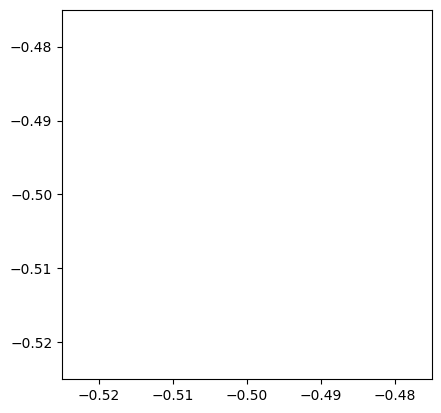

In [5]:
C = fast_xcorr2_nans(frame, template, shiftsCenter, dShift)

(array([-27.73611377,  -5.21354771]), 0.3392065)

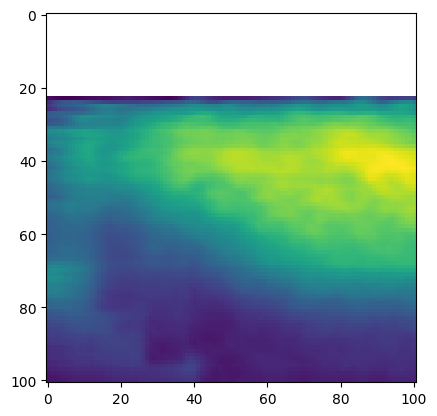

In [7]:
import cv2
import numpy as np
from utils.xcorr2_nans import xcorr2_nans as cython_xcorr2_nans

def xcorr2_nans(frame, template, shiftsCenter, dShift):
    dShift = round(dShift)  # Sanity check

    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.uint8)

    # Valid pixels of the new frame
    rows, cols = template.shape
    M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])
    tmp = cv2.warpAffine(1-cv2.dilate(np.isnan(template).astype(np.uint8), SE, iterations=1), M, (cols, rows),
                            borderMode=cv2.BORDER_CONSTANT, flags=cv2.INTER_NEAREST).astype(bool)
    fValid = np.zeros(frame.shape, dtype=bool)
    fValid[dShift:-dShift, dShift:-dShift] = ~np.isnan(frame[dShift:-dShift, dShift:-dShift]) & tmp[dShift:-dShift, dShift:-dShift]

    tValid = circshift(fValid, -shiftsCenter).astype(bool)

    F = frame.flatten(order='F')[fValid.flatten(order='F')]
    ssF = np.sqrt(F.dot(F))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    tV0, tV1 = np.where(tValid)
    tValidInd = tV0 * cols + tV1
    shifts = np.arange(-dShift, dShift+1)
    C = np.full((len(shifts), len(shifts)), np.nan, dtype="f4")
    cython_xcorr2_nans(F.ravel(), template.ravel(), tValidInd.astype("i4"), shifts.astype("i4"), cols, C)
    plt.imshow(C)
    # Find maximum of correlation map
    maxval = np.nanmax(C)
    I = np.unravel_index(np.nanargmax(C), C.shape)
    rr, cc = I
    R = maxval / ssF  # Correlation coefficient

    if 0 < rr < len(shifts) - 1 and 0 < cc < len(shifts) - 1:
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        motion = shiftsCenter + [shifts[rr] - dR, shifts[cc] - dC]
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + [shifts[rr], shifts[cc]]

    if np.any(np.isnan(motion)):
        raise ValueError('Motion result contains NaN values')

    return motion, R, C

motion, R, C = xcorr2_nans(frame, template, shiftsCenter, dShift)
motion, R

In [6]:
dShift = round(dShift)  # Sanity check

SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.uint8)

# Valid pixels of the new frame
rows, cols = template.shape
M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])
tmp = cv2.warpAffine(1-cv2.dilate(np.isnan(template).astype(np.uint8), SE, iterations=1), M, (cols, rows),
                        borderMode=cv2.BORDER_CONSTANT, flags=cv2.INTER_NEAREST).astype(bool)
fValid = np.zeros(frame.shape, dtype=bool)
fValid[dShift:-dShift, dShift:-dShift] = ~np.isnan(frame[dShift:-dShift, dShift:-dShift]) & tmp[dShift:-dShift, dShift:-dShift]

tValid = circshift(fValid, -shiftsCenter, axes=(0, 1)).astype(bool)

F = frame.flatten(order='F')[fValid.flatten(order='F')]
ssF = np.sqrt(F.dot(F))

# Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
tV0, tV1 = np.where(tValid)
tValidInd = tV0 * cols + tV1
shifts = np.arange(-dShift, dShift+1)

In [14]:
cython_xcorr2_nans(F.ravel(order = 'F'), template.ravel(), tValidInd.astype("i4"), shifts.astype("i4"), cols, C)

In [12]:
import numpy as np

# Initialize C_tmp with NaN values
C_tmp = np.full((len(shifts), len(shifts)), np.nan)

# Iterate over each shift in the first dimension
for drix in range(len(shifts)):
    # Iterate over each shift in the second dimension
    for dcix in range(len(shifts)):
        row_shift = -shifts[drix]
        col_shift = -shifts[dcix]

        # Apply circular shift using np.roll
        # axis=(0, 1) corresponds to rows and columns respectively
        shifted_tValid = circshift(tValid, shift=(row_shift, col_shift))
        
        # Create the template T from the shifted tValid
        T = template[shifted_tValid]
        
        # Compute the sum of squares of T
        ssT = np.sum(T**2)
        
        # Calculate the normalized correlation and assign it to C_tmp
        C_tmp[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)

/tmp/ipykernel_51785/514716916.py:24: RuntimeWarning: invalid value encountered in scalar divide
  C_tmp[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)


In [20]:
shifts = np.arange(-dShift, dShift + 1, dtype=int)
C = np.full((len(shifts), len(shifts)), np.nan)

for drix in range(len(shifts)):
    for dcix in range(len(shifts)):
        shifted_tValid = np.roll(tValid, circshift=(-shifts[drix], -shifts[dcix]), axis=(0, 1))
        T = template[shifted_tValid]
        ssT = np.sum(T ** 2)
        C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)

/tmp/ipykernel_51785/3666360209.py:1: RuntimeWarning: overflow encountered in scalar negative
  shifts = np.arange(-dShift, dShift + 1, dtype=int)


/tmp/ipykernel_51785/2968574587.py:1: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(C)
/tmp/ipykernel_51785/2968574587.py:1: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(C)


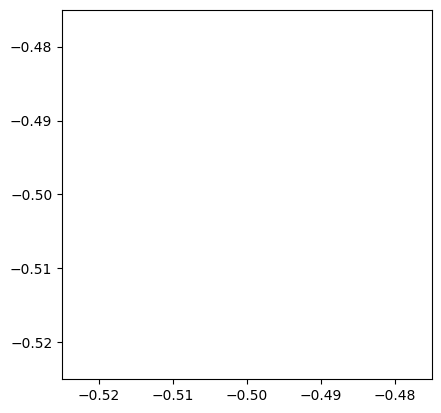

In [21]:
plt.imshow(C)

In [13]:
shifted_tValid

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [9]:
tValid_mat = loadmat('/root/capsule/scratch/tvalid.mat')['tValid']

In [10]:
import numpy as np

# Perform the comparison, treating NaNs as equal
comparison = (tValid_mat == tValid) | (np.isnan(tValid_mat) & np.isnan(tValid))

# Count the number of True and False values
num_true = np.sum(comparison)
num_false = np.size(comparison) - num_true

print(f"Number of True values: {num_true}")
print(f"Number of False values: {num_false}")

Number of True values: 33288
Number of False values: 0


# Testing XcorreNan

In [1]:
import os
import time
import numpy as np
import h5py
import numpy.ma as ma
from jnormcorre.motion_correction import MotionCorrect
from ScanImageTiffReader import ScanImageTiffReader
from scipy.fft import fft2
import cv2
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
from scipy.ndimage import binary_dilation
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.cluster.hierarchy import fcluster
from scipy.ndimage import convolve, shift
from tifffile import tifffile
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numba import jit, int64, float32, prange
from utils.xcorr2_nans import xcorr2_nans as cython_xcorr2_nans

In [2]:
dShift = loadmat('/root/capsule/scratch/xcorrnan.mat')['dShift'][0][0]
frame = loadmat('/root/capsule/scratch/xcorrnan.mat')['frame']
shiftsCenter = loadmat('/root/capsule/scratch/xcorrnan.mat')['shiftsCenter'].squeeze()
template = loadmat('/root/capsule/scratch/xcorrnan.mat')['template']

In [3]:
def circshift(arr, shift, axes=None):
    """
    Circularly shift the elements of an array.

    Parameters:
    - arr (np.ndarray): Input array to be shifted.
    - shift (int, list, or np.ndarray): Number of places by which elements are shifted.
        - If an integer, the same shift is applied to all axes.
        - If a list or np.ndarray, each element specifies the shift for the corresponding axis.
    - axes (int, list of ints, or None, optional): Axis or axes along which to shift.
        - If None and shift is an integer, shift is applied to all axes.
        - If None and shift is a list/array, the length of shift must match the number of dimensions in arr.
        - Can be an integer or a list of integers corresponding to the axes.

    Returns:
    - np.ndarray: The shifted array.

    Raises:
    - ValueError: If the length of shift does not match the number of specified axes.
    """
    arr = np.asarray(arr)
    ndim = arr.ndim

    # Handle the axes parameter
    if axes is None:
        if isinstance(shift, (int, float)):
            axes = tuple(range(ndim))
            shift = (int(shift),) * ndim
        else:
            shift = tuple(int(s) for s in shift)
            if len(shift) != ndim:
                raise ValueError("Length of shift array must match number of dimensions of arr.")
            axes = tuple(range(ndim))
    else:
        if isinstance(axes, int):
            axes = (axes,)
        elif isinstance(axes, (list, tuple, np.ndarray)):
            axes = tuple(axes)
        else:
            raise ValueError("axes must be an int or a list/tuple of ints.")

        if isinstance(shift, (int, float)):
            shift = (int(shift),) * len(axes)
        else:
            shift = tuple(int(s) for s in shift)
            if len(shift) != len(axes):
                raise ValueError("Length of shift array must match number of specified axes.")

    # Apply the shifts
    for axis, s in zip(axes, shift):
        arr = np.roll(arr, shift=s, axis=axis)

    return arr

shifts datatype: <class 'numpy.ndarray'>
tValid datatype: bool
template datatype: float32
F datatype: float32
C datatype: float64


/tmp/ipykernel_18575/3721208490.py:39: RuntimeWarning: invalid value encountered in scalar divide
  C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)


(array([ -9.74373475, -44.99030818]), 0.6610296773627717)

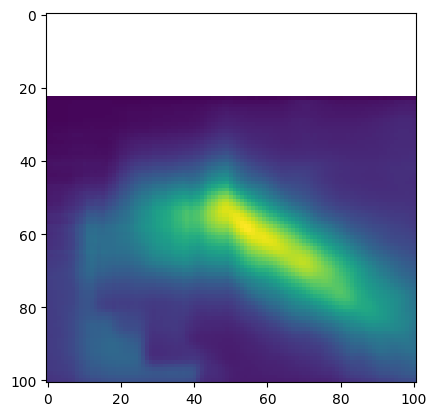

In [5]:
import cv2
import numpy as np

def xcorr2_nans(frame, template, shiftsCenter, dShift):
    dShift = round(dShift)  # Sanity check

    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.uint8)

    # Valid pixels of the new frame
    rows, cols = template.shape
    M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])
    tmp = cv2.warpAffine(1-cv2.dilate(np.isnan(template).astype(np.uint8), SE, iterations=1), M, (cols, rows),
                            borderMode=cv2.BORDER_CONSTANT, flags=cv2.INTER_NEAREST).astype(bool)
    fValid = np.zeros(frame.shape, dtype=bool)
    fValid[dShift:-dShift, dShift:-dShift] = ~np.isnan(frame[dShift:-dShift, dShift:-dShift]) & tmp[dShift:-dShift, dShift:-dShift]

    tValid = np.roll(fValid, -shiftsCenter, axis=(0, 1)).astype(bool)

    F = frame[fValid]
    ssF = np.sqrt(F.dot(F))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    tV0, tV1 = np.where(tValid)
    tValidInd = tV0 * cols + tV1

    shifts = np.arange(-dShift, dShift + 1)
    C = np.full((len(shifts), len(shifts)), np.nan)
    # Print datatypes before the loop
    for drix, shift_x in enumerate(shifts):
        for dcix, shift_y in enumerate(shifts):
            shifted_tValid = np.roll(tValid, (-shift_x, -shift_y), axis=(0, 1))
            T = template[shifted_tValid]
            ssT = np.sum(T ** 2)
            C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)
            
    # plt.imshow(C)
    # Find maximum of correlation map
    maxval = np.nanmax(C)
    I = np.unravel_index(np.nanargmax(C), C.shape)
    rr, cc = I
    R = maxval / ssF  # Correlation coefficient

    if 0 < rr < len(shifts) - 1 and 0 < cc < len(shifts) - 1:
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        motion = shiftsCenter + [shifts[rr] - dR, shifts[cc] - dC]
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + [shifts[rr], shifts[cc]]

    if np.any(np.isnan(motion)):
        raise ValueError('Motion result contains NaN values')

    return motion, R, C

motion, R, C = xcorr2_nans(frame, template, shiftsCenter, dShift)
motion, R

In [12]:
cython_xcorr2_nans.compute_shifts

<module 'utils.xcorr2_nans' from '/root/capsule/code/utils/xcorr2_nans.cpython-310-x86_64-linux-gnu.so'>

/tmp/ipykernel_59376/2292848753.py:35: RuntimeWarning: invalid value encountered in scalar divide
  C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)


468 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


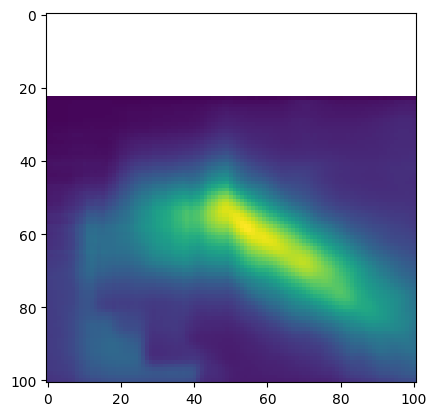

In [12]:
%timeit xcorr2_nans(frame, template, shiftsCenter, dShift)

In [11]:
# def xcorr2_nans(frame, template, shiftsCenter, dShift):
#     dShift = round(dShift)  # Sanity check

#     SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.uint8)

#     # Valid pixels of the new frame
#     rows, cols = template.shape
#     M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])
#     tmp = cv2.warpAffine(1-cv2.dilate(np.isnan(template).astype(np.uint8), SE, iterations=1), M, (cols, rows),
#                             borderMode=cv2.BORDER_CONSTANT, flags=cv2.INTER_NEAREST).astype(bool)
#     fValid = np.zeros(frame.shape, dtype=bool)
#     fValid[dShift:-dShift, dShift:-dShift] = ~np.isnan(frame[dShift:-dShift, dShift:-dShift]) & tmp[dShift:-dShift, dShift:-dShift]

#     tValid = circshift(fValid, -shiftsCenter).astype(bool)

#     F = frame.flatten(order='F')[fValid.flatten(order='F')]
#     ssF = np.sqrt(F.dot(F))

#     # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
#     tV0, tV1 = np.where(tValid)
#     tValidInd = tV0 * cols + tV1
#     shifts = np.arange(-dShift, dShift+1)
#     C = np.full((len(shifts), len(shifts)), np.nan, dtype="f4")
#     cython_xcorr2_nans(F.ravel(), template.ravel(), tValidInd.astype("i4"), shifts.astype("i4"), cols, C)
#     plt.imshow(C)
#     # Find maximum of correlation map
#     maxval = np.nanmax(C)
#     I = np.unravel_index(np.nanargmax(C), C.shape)
#     rr, cc = I
#     R = maxval / ssF  # Correlation coefficient

#     if 0 < rr < len(shifts) - 1 and 0 < cc < len(shifts) - 1:
#         # Perform superresolution upsampling
#         ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
#         dR = (1 - ratioR) / (1 + ratioR) / 2
#         ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
#         dC = (1 - ratioC) / (1 + ratioC) / 2
#         motion = shiftsCenter + [shifts[rr] - dR, shifts[cc] - dC]
#     else:
#         # The optimum is at an edge of search range; no superresolution
#         motion = shiftsCenter + [shifts[rr], shifts[cc]]

#     if np.any(np.isnan(motion)):
#         raise ValueError('Motion result contains NaN values')

#     return motion, R, C

# motion, R, C = xcorr2_nans(frame, template, shiftsCenter, dShift)
# motion, R

In [4]:
# Load MATLAB matrix
C_mat = loadmat('/root/capsule/scratch/C_mat.mat')['C']

# Ensure that C_mat and C have the same shape
if C_mat.shape != C.shape:
    print(f"Shape mismatch: C_mat shape {C_mat.shape}, C shape {C.shape}")
else:
    # Perform the comparison, treating NaNs as equal
    comparison = (C_mat == C) | (np.isnan(C_mat) & np.isnan(C))

    # Count the number of True and False values
    num_true = np.sum(comparison)
    num_false = np.size(comparison) - num_true

    print(f"Number of True values: {num_true}")
    print(f"Number of False values: {num_false}")

Number of True values: 3683
Number of False values: 6518


In [5]:
np.nanmax(np.abs(C - C_mat))

0.017578125

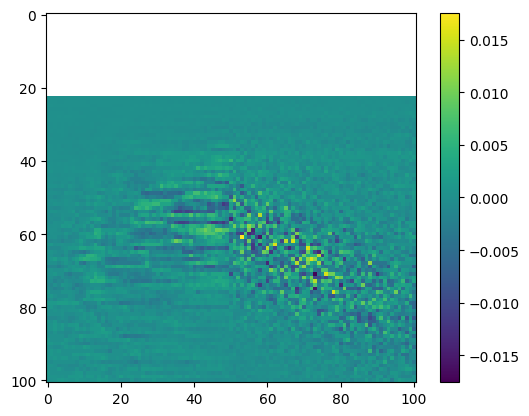

In [7]:
plt.imshow(C-C_mat)
plt.colorbar()

In [7]:
from scipy.io import loadmat

template = loadmat('/root/capsule/scratch/F_mean_Adrian.mat')['F']

In [8]:
template.shape

(46, 128)